In [5]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")



train_steps, train_losses = [], []
global_step = 0

In [6]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

# CIFAR10 dataset
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',batch_size = 64,augment = False,random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

In [7]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [8]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

# Train the model
total_step = len(train_loader)

In [9]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_steps.append(global_step)
        train_losses.append(loss.item())
        global_step += 1

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Step [704/704], Loss: 1.3095
Accuracy of the network on the 5000 validation images: 60.88 %
Epoch [2/20], Step [704/704], Loss: 0.7190
Accuracy of the network on the 5000 validation images: 68.64 %
Epoch [3/20], Step [704/704], Loss: 0.8707
Accuracy of the network on the 5000 validation images: 72.72 %
Epoch [4/20], Step [704/704], Loss: 0.9033
Accuracy of the network on the 5000 validation images: 74.3 %
Epoch [5/20], Step [704/704], Loss: 1.3448
Accuracy of the network on the 5000 validation images: 76.34 %
Epoch [6/20], Step [704/704], Loss: 0.2954
Accuracy of the network on the 5000 validation images: 76.52 %
Epoch [7/20], Step [704/704], Loss: 0.5014
Accuracy of the network on the 5000 validation images: 79.24 %
Epoch [8/20], Step [704/704], Loss: 0.0758
Accuracy of the network on the 5000 validation images: 79.8 %
Epoch [9/20], Step [704/704], Loss: 0.7292
Accuracy of the network on the 5000 validation images: 80.18 %
Epoch [10/20], Step [704/704], Loss: 0.2085
Accu

In [10]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 80.51 %


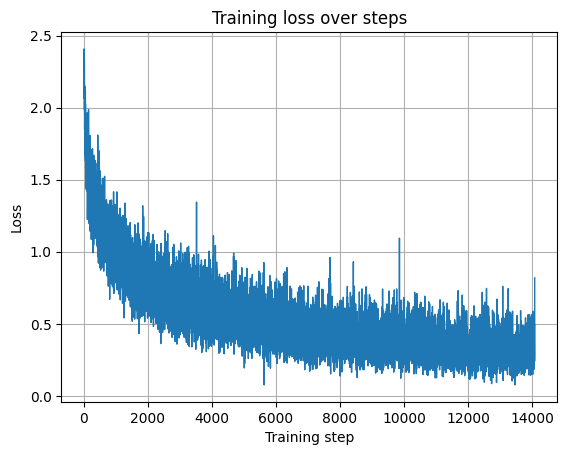

In [11]:
# 3) after training (or after each epoch), make the plot
plt.figure()
plt.plot(train_steps, train_losses, linewidth=1)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training loss over steps")
plt.grid(True)
plt.show()


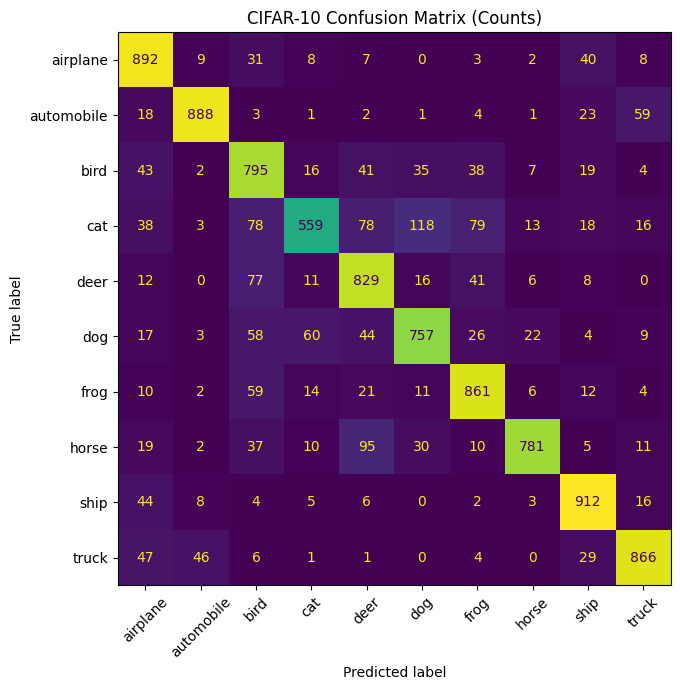

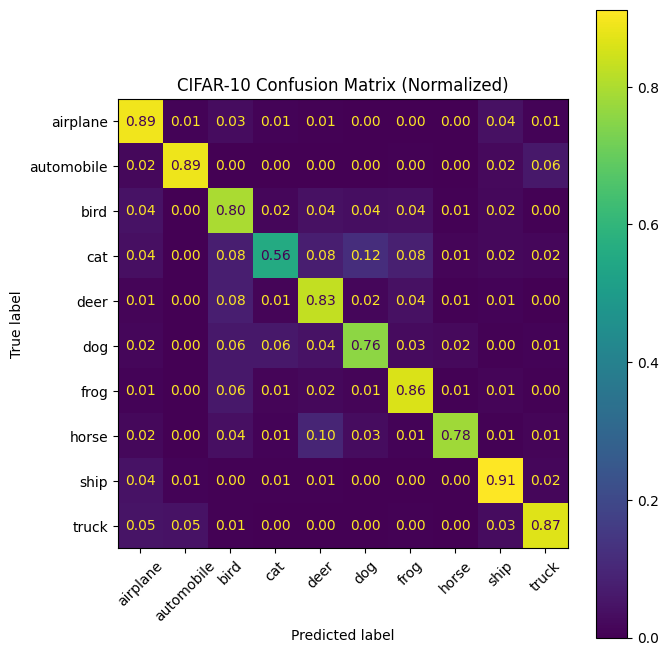

In [12]:
# === Confusion Matrix on Test Set ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy() if hasattr(labels, "cpu") else np.asarray(labels))

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Counts
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, colorbar=False)
ax.set_title("CIFAR-10 Confusion Matrix (Counts)")
plt.tight_layout(); plt.show()

# Normalized (rows sum to 1)
cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))), normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(7,7))
disp_norm.plot(ax=ax, xticks_rotation=45, colorbar=True, values_format='.2f')
ax.set_title("CIFAR-10 Confusion Matrix (Normalized)")
plt.tight_layout(); plt.show()


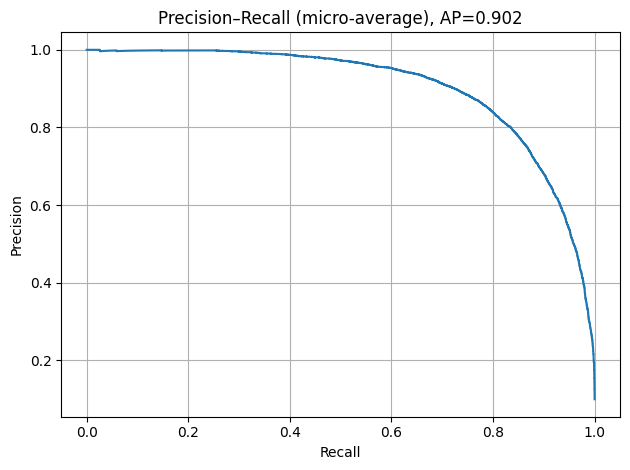

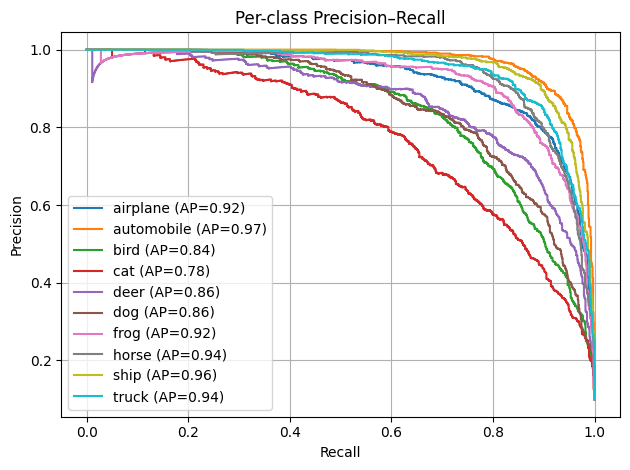

In [13]:
# === Precision–Recall Curves on Test Set ===
# Computes micro-averaged PR and per-class PR using model probabilities.


from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


model.eval()

probs_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1).cpu().numpy()  # shape [batch, num_classes]
        probs_list.append(probs)
        labels_list.append(labels.cpu().numpy() if hasattr(labels, "cpu") else np.asarray(labels))

y_true = np.concatenate(labels_list)                  # shape [N]
y_score = np.concatenate(probs_list, axis=0)          # shape [N, C]
num_classes = y_score.shape[1]

# Class names for CIFAR-10; adjust if your dataset differs
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'][:num_classes]

# Binarize labels for one-vs-rest PR
Y = label_binarize(y_true, classes=np.arange(num_classes))

# Micro-averaged PR
prec_micro, rec_micro, _ = precision_recall_curve(Y.ravel(), y_score.ravel())
ap_micro = average_precision_score(Y, y_score, average='micro')

plt.figure()
plt.step(rec_micro, prec_micro, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall (micro-average), AP={ap_micro:.3f}')
plt.grid(True)
plt.tight_layout()
plt.show()

# Per-class PR overlay
plt.figure()
for i, name in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(Y[:, i], y_score[:, i])
    ap = average_precision_score(Y[:, i], y_score[:, i])
    plt.step(rec, prec, where='post', label=f'{name} (AP={ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Per-class Precision–Recall')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

Top-1 prediction: dog (0.998)

Top-5 predictions:
dog         0.998
bird        0.002
cat         0.000
deer        0.000
frog        0.000


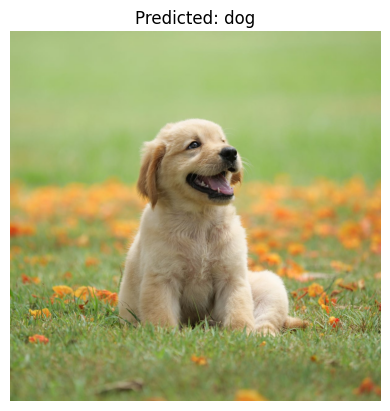

In [18]:
import requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# 1) pick any web image
# image_url = "https://d2v1gjawtegg5z.cloudfront.net/posts/preview_images/000/015/155/original/fordpickup.png?1717090124"  # <- change this
# image_url = "https://cdn.britannica.com/17/126517-050-9CDCBDDF/semi-semitrailer-truck-tractor-highway.jpg?w=300"
image_url = "https://hips.hearstapps.com/hmg-prod/images/dog-puppy-on-garden-royalty-free-image-1586966191.jpg?crop=0.752xw:1.00xh;0.175xw,0&resize=1200:*"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# 2) use the SAME preprocessing as your test loader
normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)
preprocess = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    normalize,
])

input_tensor = preprocess(img).unsqueeze(0).to(device)  # shape [1, 3, 227, 227]

# 3) make sure the model is in eval mode
model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = torch.softmax(logits, dim=1)[0]  # shape [10]

# 4) CIFAR-10 class names (same as in your confusion-matrix cell)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# 5) get top-1 (and show top-5 just to be nice)
top1_prob, top1_idx = torch.max(probs, dim=0)
print(f"Top-1 prediction: {class_names[top1_idx.item()]} ({top1_prob.item():.3f})")

top5_prob, top5_idx = torch.topk(probs, k=5)
print("\nTop-5 predictions:")
for p, idx in zip(top5_prob, top5_idx):
    print(f"{class_names[idx.item()]:10s}  {p.item():.3f}")

# 6) show the image you just classified
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {class_names[top1_idx.item()]}")
plt.show()
